In [578]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [565]:
from unagi import hsc
from unagi import mask
from unagi import config
from unagi import plotting
from unagi.task import hsc_cutout

s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide')

### Example of a mask plane

In [428]:
# Download an example mask plane
coord = SkyCoord(150.0913, 2.2059, frame='icrs', unit='deg')

cutout_test = hsc_cutout(coord, cutout_size=20.0 * u.arcsec, filters='i', archive=s18a, 
                         use_saved=False, verbose=True, save_output=False, mask=True)

# Retrieving cutout image in filter: i


#### "Library" of mask planes

* HSC data reduced by different versions of `hscPipe` have different number and definitions for the bitmask planes. 
* For example, `PDR1` has 16 allowed bitmask planes, while internal `DR2` has 32 mask planes.  
* Not all mask planes are used, some of them are just placeholders for future usage.

In [566]:
# BitMasks class holds information about the mask planes for a given dataset. 
s18a_mask = mask.BitMasks(data_release='s18a')

s18a_mask.show_table()

idx,bits,name,meaning,color,value
0,0,BAD,Bad pixel,red,1
1,1,SAT,Source footprint includes saturated pixels,tab:purple,2
2,2,INTRP,Source footprint includes interpolated pixels,tab:orange,4
3,3,CR,Source footprint includes suspected CR pixels,tab:pink,8
4,4,EDGE,Source is close to the edge of the CCD,tab:olive,16
5,5,DETECTED,Pixel with detection above the threshold,tab:blue,32
6,6,DETECTED_NEGATIVE,Pixel in footprint that is detected as a negative object,gray,64
7,7,SUSPECT,Source footprint includes suspect pixels,orangered,128
8,8,NO_DATA,No useful data,black,256
9,9,BRIGHT_OBJECT,Bright star mask,tab:brown,512


In [567]:
# Check whether a mask plane is available
s18a_mask.check('CLIPPED')

True

In [568]:
# Get the index of a mask plane in the "library"
s18a_mask.get_index('DETECTED')

5

#### Using the HSC mask plane 

* `mask` locates in the 2nd HDU of a HSC coadd image.

In [608]:
bitmask = cutout_test[2].data

mask_test = mask.Mask(bitmask, data_release='s18a')

#### Extract a single layer of mask 

* Use the `extract()` method, you can use the name of the mask plane or the bit value as input
* Default output format is `np.uint8` (pixel value 1 means masked, 0 means unmasked).
* The `show=True` option will return a `np.uint16` version of the mask array to display
* You can display this layer of mask using the `display()` method.

In [439]:
mask_1 = mask_test.extract('DETECTED')
mask_2 = mask_test.extract(5)

assert np.all(mask_1 == mask_2)

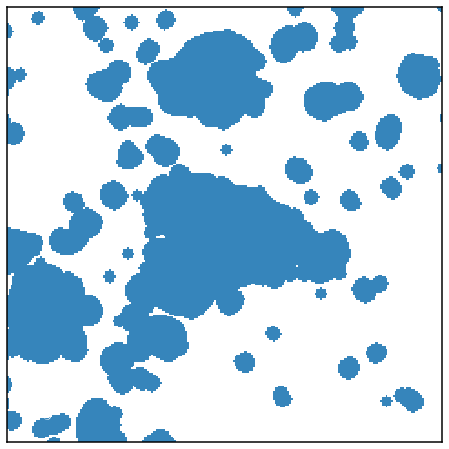

In [558]:
_ = mask_test.display('DETECTED')

* It is also possible to extract or display multiple layers of masks at the same time

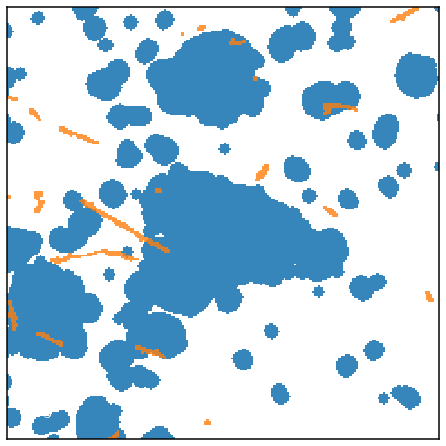

In [559]:
mask_3 = mask_test.extract(['DETECTED', 'INTRP', 'SAT'])

_ = mask_test.display(['DETECTED', 'INTRP'], alpha_list=[0.9, 0.8])

### Enlarge the mask by convolving it with a Gaussian kernel

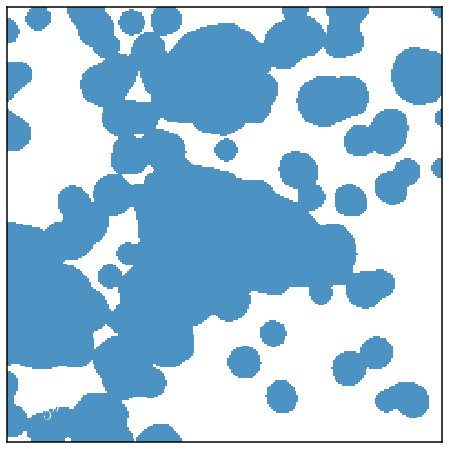

In [560]:
_ = plotting.display_single(
    mask_test.enlarge('DETECTED', sigma=2.0), stretch='linear',
    cmap=mask_test.get_cmap('DETECTED'), alpha=0.8)

#### Combine multiple layers of masks

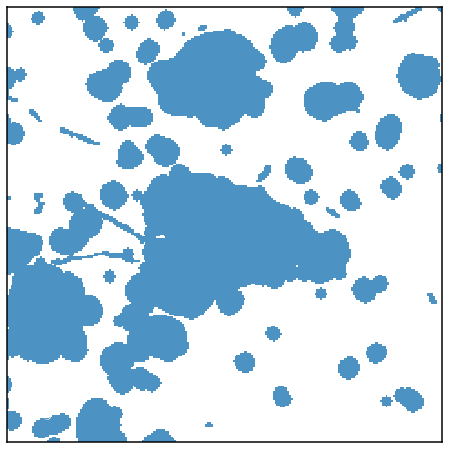

In [561]:
_ = plotting.display_single(
    mask_test.combine(['DETECTED', 'INTRP']), stretch='linear',
    cmap=mask_test.get_cmap('DETECTED'), alpha=0.8)

#### Remove one or multiple layers of masks

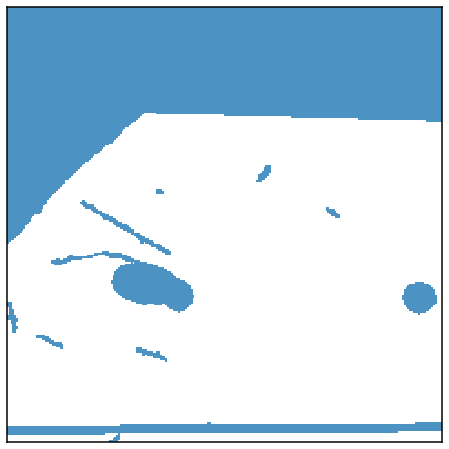

In [593]:
_ = plotting.display_single(
    mask_test.clean(['DETECTED', 'INTRP']), stretch='linear',
    cmap=mask_test.get_cmap('DETECTED'), alpha=0.8)

### Identify and display the used mask planes

In [655]:
# Names of the mask planes that are used 
print(mask_test.name_used())

['INTRP', 'CR', 'DETECTED', 'BRIGHT_OBJECT', 'REJECTED', 'CLIPPED', 'SENSOR_EDGE', 'INEXACT_PSF']


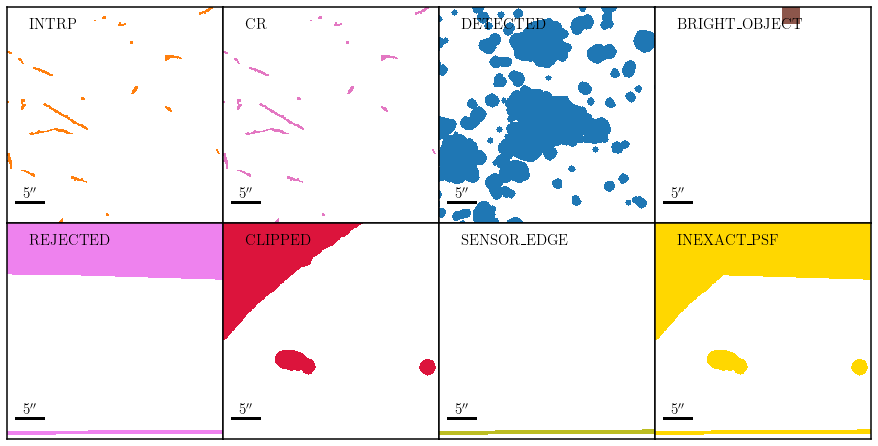

In [660]:
_, mm = mask_test.show_used()